In [1]:
import sys
if sys.path[0] != '/mnt/home/landerson/.local/lib/python3.6/site-packages':
    sys.path.insert(0, '/mnt/home/landerson/.local/lib/python3.6/site-packages/astroML-0.3-py3.6.egg')
    sys.path.insert(0, '/mnt/home/landerson/.local/lib/python3.6/site-packages/xdgmm-1.0.9-py3.6.egg') 
    sys.path.insert(0, '/mnt/home/landerson/.local/lib/python3.6/site-packages')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib as mpl
from scipy import stats
from dustmaps.sfd import SFDQuery
from dustmaps.bayestar import BayestarQuery
import astropy.coordinates as coord
import astropy.units as u
import scipy.stats
from astropy.table import Table, unique, Column, hstack, vstack
import healpy as hp
from xdgmm import XDGMM

/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def dust(ra, dec, distance, max_samples=10, mode='median'):
    c = coord.SkyCoord(ra, dec, distance=distance)
    sfd = SFDQuery()
    bayes = BayestarQuery(max_samples=max_samples)

    return sfd(c), bayes(c, mode=mode, return_flags=False) #, iphas(c, mode=mode), marshall(c), chen(c)
def getDust(G, bp, rp, ebv, maxnit=100):
    """ Compute the Gaia extinctions assuming relations from Babusieux
    Arguments: G, bp, rp, E(B-V)
    maxnit -- number of iterations
    Returns extinction in G,bp, rp
    Author: Sergey Koposov skoposov@cmu.edu
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1
    print(scipy.stats.scoreatpercentile(delta[np.isfinite(delta)], 99))
    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp

In [3]:
#data = Table.read('dust-result.fits.gz')
datahigh = Table.read('dustHighLat-result.fits.gz')

In [4]:
datalow = Table.read('dustLowLat-result.fits.gz')

## All sky with parallax S/N > 20 and good photometry: 25.5 Million Stars out to 3 kpc

In [5]:
data = vstack((datahigh, datalow))

In [6]:
c = coord.SkyCoord(data['ra'], data['dec'], distance=1./data['parallax']/u.mas*u.kpc)
galc = c.transform_to(coord.Galactic)
galactic = c.transform_to(coord.Galactocentric)
highlat = np.abs(galc.b) > 45*u.deg

In [7]:
absmag = data['w2mpro'] - 5.*np.log10(1./(data['parallax']/1e2))
color = data['h_m'] - data['w2mpro']

In [8]:
sfddust, bayesdust = dust(data['ra'], data['dec'], 1./data['parallax']/u.mas*u.kpc, max_samples=10, 
                          mode='median')


/mnt/home/landerson/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 7820873 results
  r = func(a, **kwargs)


In [9]:
def matrixize(data1, data2, err1, err2):
    """
    vectorize the 2 pieces of data into a 2D mean and 2D covariance matrix
    """
    X = np.vstack([data1, data2]).T
    Xerr = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    Xerr[:, diag, diag] = np.vstack([err1**2., err2**2.]).T
    return X, Xerr

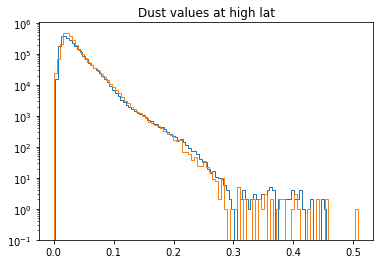

In [10]:
plt.hist(sfddust[highlat & ~np.isnan(bayesdust)], log=True, histtype='step', bins=100)
plt.hist(bayesdust[highlat & ~np.isnan(bayesdust)], log=True, histtype='step', bins=100)
plt.title('Dust values at high lat')

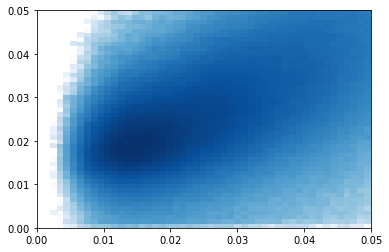

In [11]:
nbins = 50
ybins = np.linspace(0, 0.05, nbins)
xbins = np.linspace(0, 0.05, nbins)

H, xe, ye = np.histogram2d(sfddust[highlat & ~np.isnan(sfddust) & ~np.isnan(bayesdust)], 
                       bayesdust[highlat & ~np.isnan(sfddust) & ~np.isnan(bayesdust)], 
                       bins=(xbins, ybins))
im = plt.pcolormesh(xe, ye, H.T,
  norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)


In [12]:
colorErr = np.sqrt(data['h_msigcom']**2 + data['w2mpro_error']**2.)
absmagErr = data['w2mpro_error']
indices = highlat & (absmag < 2) & (sfddust < 0.05) 
print(np.sum(indices))

238303


In [13]:
X, Xerr = matrixize(color[indices], absmag[indices], colorErr[indices], absmagErr[indices])
ncomp = 256
try:
    xdgmm = XDGMM(filename='rjce_lowdust_{0}G.fits'.format(ncomp))
except IOError:
    xdgmm = XDGMM(method='Bovy')
    xdgmm.n_components = ncomp
    xdgmm = xdgmm.fit(X, Xerr)
    xdgmm.save_model('rjce_lowdust_{0}G.fits'.format(ncomp))
sample = xdgmm.sample(np.sum(indices))

In [14]:
def plotXdgmm(xdgmm, ax, c='k', lw=1, label='prior', step=0.001):
    ts = np.arange(0, 2. * np.pi, step) #magic
    amps = xdgmm.weights
    mus = xdgmm.mu
    Vs = xdgmm.V
    for gg in range(xdgmm.n_components):
        if amps[gg] == np.max(amps):
            label=label
        else:
            label=None
        w, v = np.linalg.eigh(Vs[gg])
        points = np.sqrt(w[0]) * (v[:, 0])[:,None] * (np.cos(ts))[None, :] + \
                 np.sqrt(w[1]) * (v[:, 1])[:,None] * (np.sin(ts))[None, :] + \
                 mus[gg][:, None]
        ax.plot(points[0,:], points[1,:], c, lw=lw, alpha=amps[gg]/np.max(amps), rasterized=True, label=label)

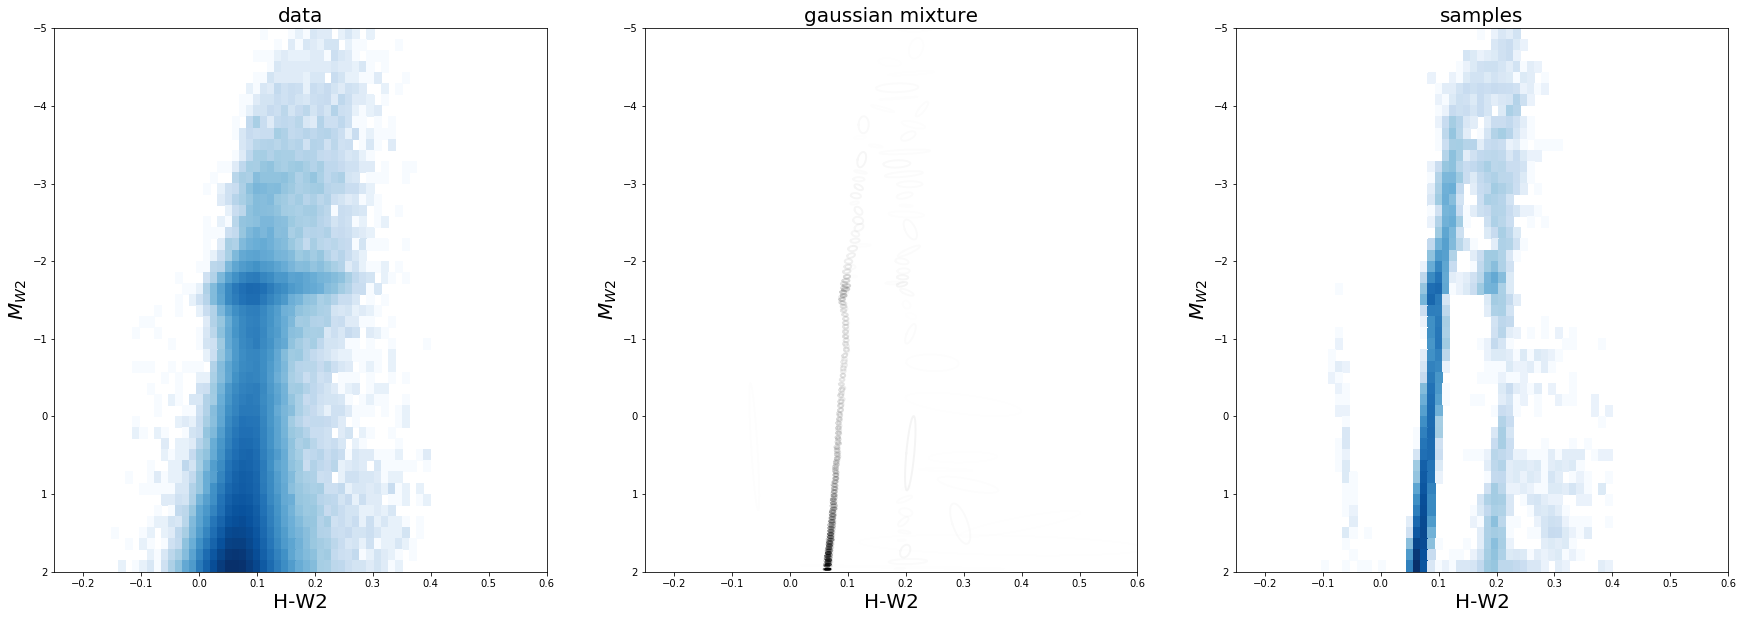

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

nbins = 50
xbins = np.linspace(-0.2, 0.4, nbins)
ybins = np.linspace(-5, 2, nbins)

for c, ab, a in zip([color[indices], sample[:,0]], [absmag[indices], sample[:,1]], [ax[0], ax[2]]):
    H, xe, ye = np.histogram2d(c, 
                           ab, 
                           bins=(xbins, ybins))
    im = a.pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
    im.set_rasterized(True)

plotXdgmm(xdgmm, ax[1], lw=2)

labels = ['data', 'gaussian mixture', 'samples']

for a , l in zip(ax, labels):
    a.set_xlabel('H-W2', fontsize=20)
    a.set_ylabel('$M_{W2}$', fontsize=20)
    a.set_xlim(-0.25, 0.6)
    a.set_ylim(2, -5)
    a.set_title(l, fontsize=20)


In [16]:
def multiplyGaussians(a, A, b, B):
    """
    multiple the two gaussians N(a, A) and N(b, B) to generate z_c*N(c, C)
    """
    Ainv = np.linalg.inv(A)
    Binv = np.linalg.inv(B)
    C = np.linalg.inv(Ainv + Binv)
    Cinv = np.linalg.inv(C)
    d = len(a)
    c = np.dot(np.dot(C,Ainv),a) + np.dot(np.dot(C,Binv),b)

    exponent = -0.5*(np.dot(np.dot(np.transpose(a),Ainv),a) + \
                     np.dot(np.dot(np.transpose(b),Binv),b) - \
                     np.dot(np.dot(np.transpose(c),Cinv),c))
    z_c= (2*np.pi)**(-d/2.)*np.linalg.det(C)**0.5*np.linalg.det(A)**-0.5*np.linalg.det(B)**-0.5*np.exp(exponent)

    return c, C, z_c

def Posterior(xdgmm, ndim, likemean, likecov, xPosterior, projectedDimension=1, nPosteriorPoints=1000, prior=False):
    """
    calculate the posterior of data likelihood mean, cov with prior xdgmm
    """
    allMeans = np.zeros((xdgmm.n_components, ndim))
    allAmps = np.zeros(xdgmm.n_components)
    allCovs = np.zeros((xdgmm.n_components, ndim, ndim))
    summedPosterior = np.zeros(len(x))

    for gg in range(xdgmm.n_components):
        #print mean2[dimension], cov2[dimension], xdgmm.mu[gg], xdgmm.V[gg]
        newMean, newCov, newAmp = multiplyGaussians(xdgmm.mu[gg], xdgmm.V[gg], likemean, likecov)
        newAmp *= xdgmm.weights[gg]
        allMeans[gg] = newMean
        allAmps[gg] = newAmp
        allCovs[gg] = newCov
        summedPosterior += st.gaussian(newMean[projectedDimension], np.sqrt(newCov[projectedDimension, projectedDimension]), x, amplitude=newAmp)
        #individualPosterior[gg,:] = st.gaussian(newMean[projectedDimension], np.sqrt(newCov[projectedDimension, projectedDimension]), x, amplitude=newAmp)


    if not prior: summedPosterior = summedPosterior/np.sum(allAmps)
    #summedPrior = summedPrior#/np.sum(allpriorAmps)
    return allMeans, allAmps, allCovs, summedPosterior


In [17]:
likemean, likecov = matrixize(color[indices][0], 
                              absmag[indices][0], 
                              colorErr[indices][0], 
                              absmagErr[indices][0])

## visualization of high latitude RJCE CMD

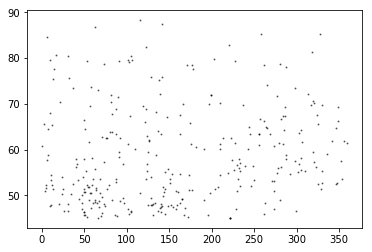

In [18]:
plt.plot(galc.l[indices & (color > 0.25) & (galc.b > 0)].value, 
         galc.b[indices & (color > 0.25) & (galc.b > 0)].value, 
         'ko', markersize=1, alpha=0.5)

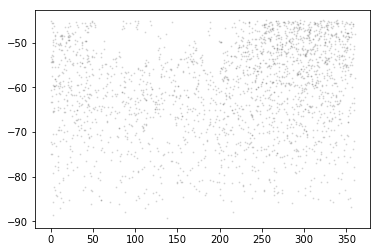

In [19]:
plt.plot(galc.l[indices & (color > 0.2) & (galc.b < 0)].value, galc.b[indices & (color > 0.2) & (galc.b < 0)].value, 'ko', markersize=1, alpha=0.1)

/mnt/home/landerson/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


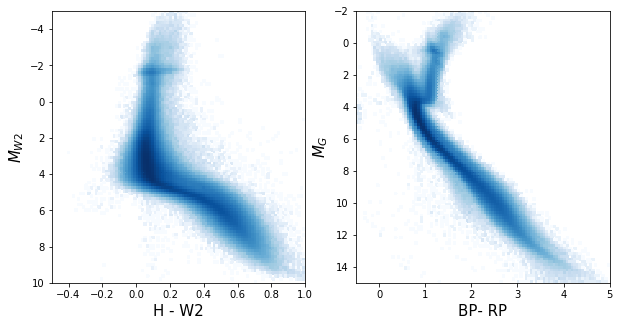

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
colors = [color, data['phot_bp_mean_mag'] - data['phot_rp_mean_mag']]
absmags = [absmag, data['phot_g_mean_mag'] - 5.*np.log10(1./(data['parallax']/1e2))]
minmags = [-5, -2]
maxmags = [10, 15]
mincolor = [-0.5, -0.5]
maxcolor = [1, 5]
for i, (a, c, ab) in enumerate(zip(ax, colors, absmags)):
    nbins = 100
    ybins = np.linspace(minmags[i], maxmags[i], nbins)
    xbins = np.linspace(mincolor[i], maxcolor[i], nbins)

    H, xe, ye = np.histogram2d(c[highlat & (sfddust < 0.05)], 
                           ab[highlat & (sfddust < 0.05)], 
                           bins=(xbins, ybins))
    im = a.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
    im.set_rasterized(True)
    a.invert_yaxis()
ax[0].set_xlabel('H - W2', fontsize=15)
ax[0].set_ylabel('$M_{W2}$', fontsize=15)

ax[1].set_xlabel('BP- RP', fontsize=15)
ax[1].set_ylabel('$M_G$', fontsize=15)
#plt.colorbar(im)
#ax[0].axvline(0.08, c='black', linewidth=2, label='previous model')
plt.legend(loc='upper right')
plt.savefig('cmd_rjce_gaia.pdf')
plt.savefig('cmd_rjce_gaia.png')

/mnt/home/landerson/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


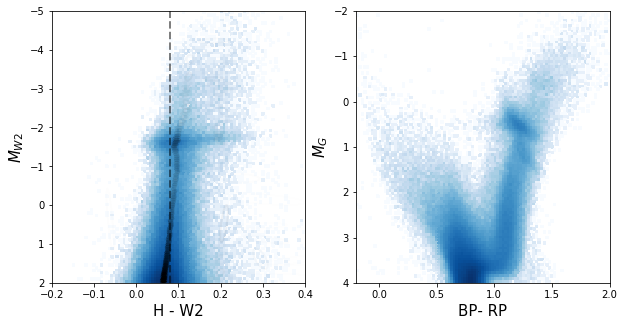

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
colors = [color, data['phot_bp_mean_mag'] - data['phot_rp_mean_mag']]
absmags = [absmag, data['phot_g_mean_mag'] - 5.*np.log10(1./(data['parallax']/1e2))]
minmags = [-5, -2]
maxmags = [2, 4]
mincolor = [-0.2, -0.2]
maxcolor = [0.4, 2]
for i, (a, c, ab) in enumerate(zip(ax, colors, absmags)):
    nbins = 100
    ybins = np.linspace(minmags[i], maxmags[i], nbins)
    xbins = np.linspace(mincolor[i], maxcolor[i], nbins)

    H, xe, ye = np.histogram2d(c[highlat & (sfddust < 0.05)], 
                           ab[highlat & (sfddust < 0.05)], 
                           bins=(xbins, ybins))
    im = a.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
    im.set_rasterized(True)
    a.invert_yaxis()
ax[0].set_xlabel('H - W2', fontsize=15)
ax[0].set_ylabel('$M_{W2}$', fontsize=15)

ax[1].set_xlabel('BP- RP', fontsize=15)
ax[1].set_ylabel('$M_G$', fontsize=15)
#plt.colorbar(im)
plotXdgmm(xdgmm, ax[0], lw=2)
ax[0].set_xlim(mincolor[0], maxcolor[0])
ax[0].set_ylim(maxmags[0], minmags[0])
ax[0].axvline(0.08, c='black', linewidth=2, label='previous model', linestyle='--', alpha=0.5)
plt.legend(loc='upper right')
plt.savefig('cmd_rjce_gaia.pdf')
plt.savefig('cmd_rjce_gaia.png')

## Hacky test that there isn't much dust extinction at high lattitudes using 3D dust map, just to test

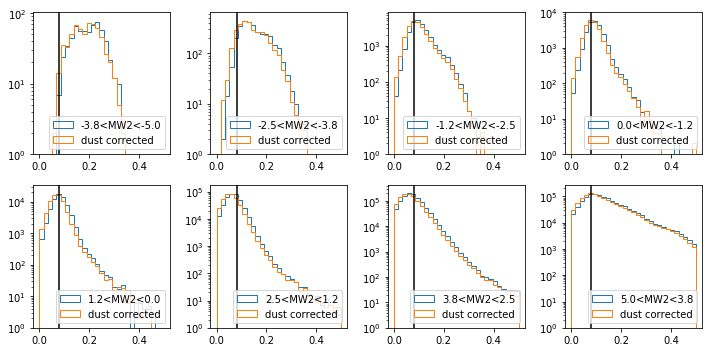

In [22]:
Q_H = 0.449
dustvalues = bayesdust*Q_H
dustvalues[np.isnan(dustvalues)] = 0.0

fig, ax = plt.subplots(2, 4, figsize=(10, 5))
ax = ax.flatten()

nAbsMagbins = 9
nColorbins = 30
minAbsMag = -5
maxAbsMag = 5
absMagbins = np.linspace(minAbsMag, maxAbsMag, nAbsMagbins)
#color=iter(plt.cm.Blues(np.linspace(0,1, nw2bins)))
colorbins = np.linspace(0, 0.5, nColorbins)
for i in range(nAbsMagbins-1):
    ibin = (absmag > absMagbins[i]) & (absmag <= absMagbins[i+1])
    ax[i].hist((color)[highlat & ibin], 
               bins=colorbins, histtype='step', log=True, 
               label='{0:.1f}<MW2<{1:.1f}'.format(absMagbins[i+1], absMagbins[i]))

    ax[i].hist((color - dustvalues)[highlat & ibin], 
               bins=colorbins, histtype='step', log=True, 
               label='dust corrected')
    ax[i].legend(loc='lower right')
    ax[i].set_ylim(1,)
    ax[i].axvline(0.08, color='black', label='prev model')
plt.tight_layout()
plt.savefig('cmd_slice_dust_rjce.pdf')
plt.savefig('cmd_slice_dust_rjce.png')

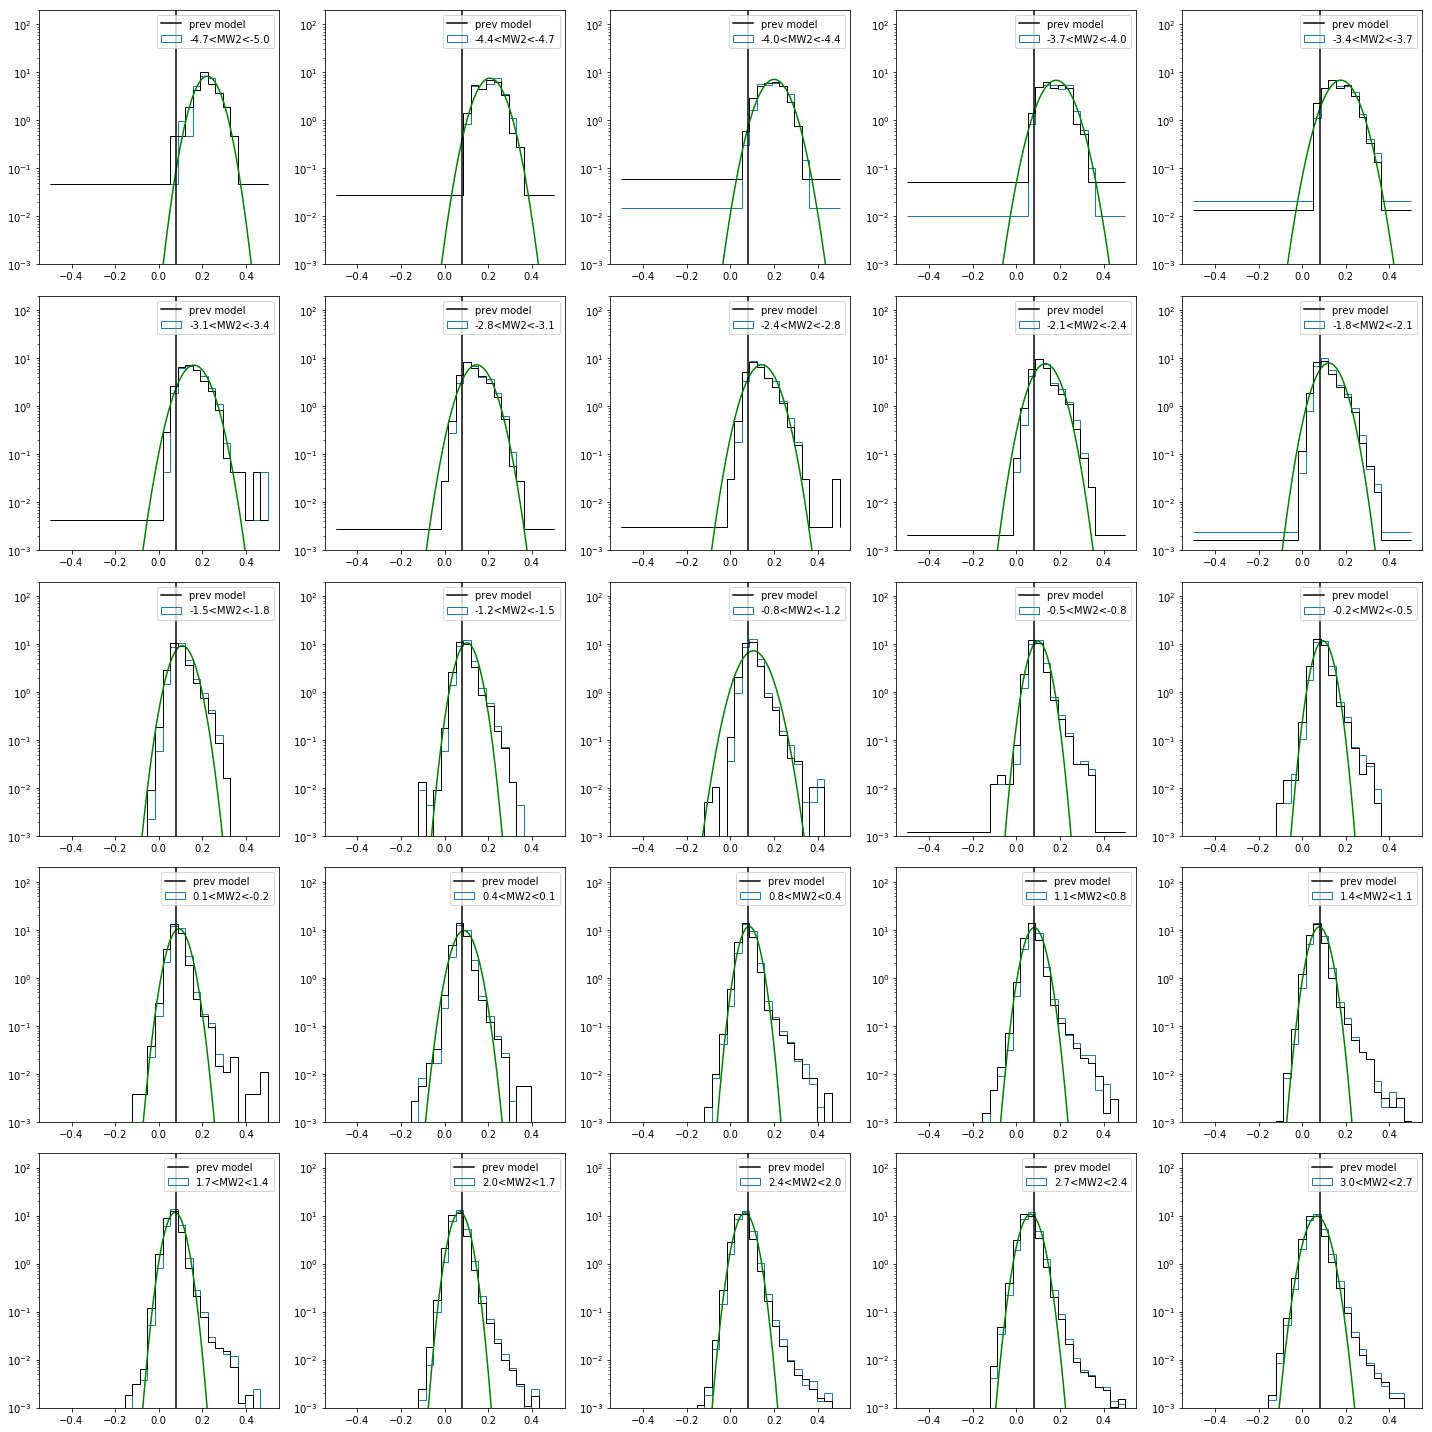

In [23]:
colormin = -0.5
colormax = 0.5
absMagMin = -5
absMagMax = 3
fig, ax = plt.subplots(5, 5, figsize=(20, 20))
ax = ax.flatten()

nAbsMagbins = 26
ncolorbins = 30
absMagbins = np.linspace(absMagMin, absMagMax, nAbsMagbins)
#color=iter(plt.cm.Blues(np.linspace(0, 1, nw2bins)))
colorbins = np.linspace(colormin, colormax, ncolorbins)

mean = np.zeros(nAbsMagbins - 1)
std  = np.zeros(nAbsMagbins - 1)
for i in range(nAbsMagbins-1):
    ibin = (absmag > absMagbins[i]) & (absmag <= absMagbins[i+1])
    ax[i].hist(color[highlat & (sfddust < 0.05) & ibin], 
               bins=colorbins, histtype='step', log=True, 
               label='{0:.1f}<MW2<{1:.1f}'.format(absMagbins[i+1], absMagbins[i]), normed=True)
    ax[i].hist((color - dustvalues)[highlat & (sfddust < 0.05) & ibin], 
               bins=colorbins, histtype='step', log=True, color='black', normed=True, label=None)
    ser = color[highlat & ibin]
    lnspc = np.linspace(colormin, colormax, len(ser))
    # lets try the normal distribution first
    m, s = stats.norm.fit(ser) # get mean and standard deviation  
    pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
    ax[i].plot(lnspc, pdf_g, color='green') # plot itd
    mean[i] = m
    std[i] = s
    
    # exactly same as above
    #ag,bg,cg = stats.alpha.fit(ser)  
    #pdf_alpha = stats.alpha.pdf(lnspc, ag, bg,cg)  
    #ax[i].plot(lnspc, pdf_alpha, color='red')

    # guess what :) 
    #ab,bb,cb,db = stats.beta.fit(ser)  
    #pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
    #ax[i].plot(lnspc, pdf_beta, label="Beta", color='purple')


    ax[i].set_ylim(0.001,200)
    ax[i].axvline(0.08, color='black', label='prev model')
    ax[i].legend(loc='upper right')
plt.tight_layout()
plt.savefig('cmd_slice_fit_rjce.pdf')
plt.savefig('cmd_slice_fit_rjce.png')

In [24]:
class MixtureModel(scipy.stats.rv_continuous):
    def __init__(self, submodels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.submodels = submodels

    def _pdf(self, x):
        pdf = self.submodels[0].pdf(x)
        for submodel in self.submodels[1:]:
            pdf += submodel.pdf(x)
        pdf /= len(self.submodels)
        return pdf

    def rvs(self, size):
        submodel_choices = np.random.randint(len(self.submodels), size=size)
        submodel_samples = [submodel.rvs(size=size) for submodel in self.submodels]
        rvs = np.choose(submodel_choices, submodel_samples)
        return rvs



In [25]:
import scipy.optimize as op
import emcee

In [26]:
import corner

In [38]:
def lnprior(theta, xdgmm, I=np.zeros((1, 2, 2))):
    hw2_model, mw2_model, Ak = theta
    if (-5 <= Ak) & (Ak<=5):
        return xdgmm.score_samples(np.vstack([hw2_model, mw2_model]).T, I)[0]
    return -np.inf


In [28]:
def lnprob(theta, Y, Y_err, xdgmm):
    lp = lnprior(theta, xdgmm)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, Y, Y_err)

In [29]:
def lnlike(theta, Y, Y_err):
    Aw2_Ak = 0.43
    (hw2_model, mw2_model, Ak) = theta
    Y_model = np.vstack([hw2_model + Ak/0.918, mw2_model + Ak*Aw2_Ak]).T
    #print(Y_model)
    inv_sigma_2 = np.linalg.inv(Y_err**2) # + Y_model**2*np.exp(2*lnf))
    #print(inv_sigma_2) #, Y_err**2 + Y_model**2*np.exp(2*lnf), Y_err**2, Y_model**2*np.exp(2*lnf))
    #print(Y-Y_model)
    #print(np.log(inv_sigma_2))
    result = -0.5*(np.sum(np.dot(np.dot(Y - Y_model, inv_sigma_2[0]), np.transpose(Y - Y_model)) + 
                          np.log(np.linalg.det(Y_err[0]**2))))
    #print(result)
    return result


In [30]:
xtest, xerrtest = matrixize(2.1, -2.1, 0.2, 0.1)
lnlike([2.1, -2.0, 0.0], xtest, xerrtest)

-42.17595398914378

In [39]:
nll = lambda *args: -lnlike(*args)
nlp = lambda *args: -lnprob(*args)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

nbins = 50
xbins = np.linspace(-0.2, 0.4, nbins)
ybins = np.linspace(-5, 2, nbins)

for c, ab, a in zip([color[indices], sample[:,0]], [absmag[indices], sample[:,1]], [ax[0], ax[2]]):
    H, xe, ye = np.histogram2d(c, 
                           ab, 
                           bins=(xbins, ybins))
    im = a.pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
    im.set_rasterized(True)

plotXdgmm(xdgmm, ax[1], lw=2)

labels = ['data', 'gaussian mixture', 'samples']

for a , l in zip(ax, labels):
    a.set_xlabel('H-W2', fontsize=20)
    a.set_ylabel('$M_{W2}$', fontsize=20)
    a.set_xlim(-0.25, 0.6)
    a.set_ylim(2, -5)
    a.set_title(l, fontsize=20)


for i in range(3):
    Y, Y_err = matrixize(color[indices][i], 
                         absmag[indices][i], 
                         colorErr[indices][i], 
                         absmagErr[indices][i])
    Ak_guess = 0.01
    hw2_guess = color[indices][i]
    mw2_guess = absmag[indices][i]
    result = op.minimize(nlp, [hw2_guess, mw2_guess, Ak_guess], 
                     args=(Y, Y_err, xdgmm))
    print(result["x"])

    ndim, nwalkers = 3, 50
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(Y, Y_err, xdgmm), threads=15)
    sampler.run_mcmc(pos, 200)
    
    ax[0].scatter(color[indices][i], absmag[indices][i], s=100, c='black')
    ax[0].scatter(result['x'][0], result['x'][1], s=100, c='red')
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
    
    hw2_mcmc, mw2_mcmc, ak_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                           axis=0)))
    print(hw2_mcmc, mw2_mcmc, ak_mcmc)
    ax[0].scatter(hw2_mcmc[0], mw2_mcmc[0], s=100, c='purple')
    fig = corner.corner(samples, labels=["$H-W2$", "$M_{W2}$", "$A_k$", "$\ln\,f$"],
                      truths=[result['x'][0], result['x'][1], result['x'][2]])
    #fig.savefig("triangle.png")

    #print([meanhw2_true, meanmw2_true, Ak_true, np.log(f_true)])

[0.06594347 1.83452099 0.02667103]
(0.06683003867561907, 0.004255818264497807, 0.004088445772425467) (1.8349052766805218, 0.0018509264636918932, 0.0016507693243255073) (0.025848576246309332, 0.0038909855840318364, 0.003988046346859338)
[ 0.39227129  1.39419478 -0.25269891]


In [173]:
hw2_mcmc, mw2_mcmc, ak_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [175]:
hw2_mcmc, mw2_mcmc, ak_mcmc

((0.06959523039340614, 0.014822917898950974, 0.006085105844676628),
 (1.8362050233093783, 0.005944438257332374, 0.002607972313916518),
 (0.022997087082057527, 0.006003156791484068, 0.013913467204259747))

0.13423644703186344 0.20713812004992993 0.048759113404299975
0.8089480749973033 0.16678885071385632 0.06634629627930842
3.044488643970078 0.10706548003117525 0.09126752320671216
4.106381941474037 0.0854823301964748 0.0894081576807396
4.3492909286800945 0.07694371911861025 0.08447907649913002
4.353877090533456 0.06402548422276615 0.07828773299121738
3.1804605484186648 0.05913621407935367 0.06284579010344164


/cm/shared/sw/pkg-old/devel/python3/3.6.2/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1612: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


2.9900629986349516 0.06274273820132481 0.057934975441751496
2.03042911046695 0.06261809971492768 0.04820353217558383
2.757627107314396 0.05117612421056553 0.05709328198317484
1.9400363649247665 0.052664449401385004 0.04685349322608193
2.0803832646994174 0.045362539793865335 0.049241898274756626
1.8621519387012624 0.03992467218380546 0.04653195397081836
1.7720704866746577 0.03351865853591055 0.04800768442818143
1.8646809295111395 0.028716891583443913 0.05558665043250953


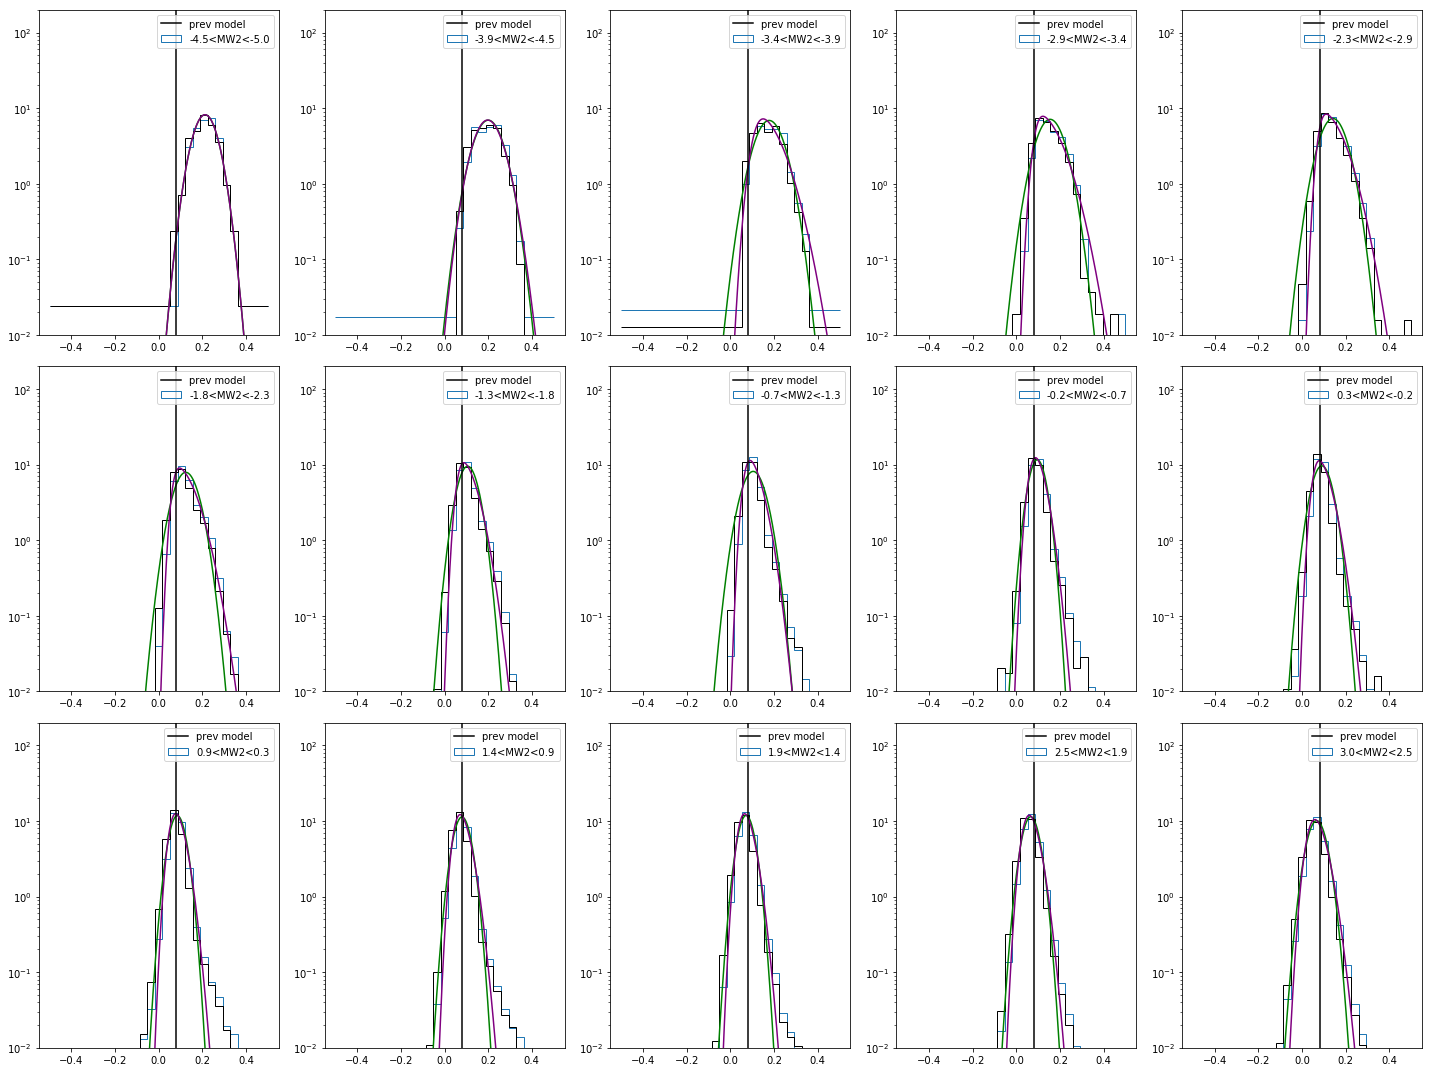

In [82]:
colormin = -0.5
colormax = 0.5
absMagMin = -5
absMagMax = 3
fig, ax = plt.subplots(3, 5, figsize=(20, 15))
ax = ax.flatten()

nAbsMagbins = 16
ncolorbins = 30
absMagbins = np.linspace(absMagMin, absMagMax, nAbsMagbins)
#color=iter(plt.cm.Blues(np.linspace(0, 1, nw2bins)))
colorbins = np.linspace(colormin, colormax, ncolorbins)

mean = np.zeros(nAbsMagbins - 1)
std  = np.zeros(nAbsMagbins - 1)
for i in range(nAbsMagbins-1):
    ibin = (absmag > absMagbins[i]) & (absmag <= absMagbins[i+1])
    ax[i].hist(color[highlat & ibin], 
               bins=colorbins, histtype='step', log=True, 
               label='{0:.1f}<MW2<{1:.1f}'.format(absMagbins[i+1], absMagbins[i]), normed=True)
    ax[i].hist((color - dustvalues)[highlat & ibin], 
               bins=colorbins, histtype='step', log=True, color='black', normed=True, label=None)
    ser = color[highlat & ibin]
    lnspc = np.linspace(colormin, colormax, len(ser))
    # lets try the normal distribution first
    m, s = stats.norm.fit(ser) # get mean and standard deviation  
    pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
    ax[i].plot(lnspc, pdf_g, color='green') # plot it
    mean[i] = m
    std[i] = s
    
    
    a, loc, scale = stats.skewnorm.fit(ser)
    print(a, loc, scale)
    pdf_skew = stats.skewnorm.pdf(lnspc, a, loc=loc, scale=scale)
    ax[i].plot(lnspc, pdf_skew, color='purple')
    
    """
    mixture_model = MixtureModel([stats.norm(m, s), stats.lognorm(shape, loc=loc, scale=scale)])
    #x_axis = np.arange(-6, 6, 0.001)
    mixture_pdf = mixture_model.pdf(lnspc)
    #mixture_rvs = mixture_gaussian_model.rvs(10)
    ax[i].plot(lnspc, mixture_pdf, color='red')
    

    mixture_model = MixtureModel([stats.norm(m, s), stats.lognorm(shape*2., loc=loc, scale=scale)])
    #x_axis = np.arange(-6, 6, 0.001)
    mixture_pdf = mixture_model.pdf(lnspc)
    #mixture_rvs = mixture_gaussian_model.rvs(10)
    ax[i].plot(lnspc, mixture_pdf, color='blue')

    # exactly same as above
    ag,bg,cg = stats.alpha.fit(ser)  
    pdf_alpha = stats.alpha.pdf(lnspc, ag, bg,cg)  
    ax[i].plot(lnspc, pdf_alpha, color='red')
    """
    # guess what :) 
    #ab,bb,cb,db = stats.beta.fit(ser)  
    #pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
    #ax[i].plot(lnspc, pdf_beta, label="Beta", color='purple')


    ax[i].set_ylim(0.01,200)
    ax[i].axvline(0.08, color='black', label='prev model')
    ax[i].legend(loc='upper right')
plt.tight_layout()


In [ ]:

fig, ax = plt.subplots(1,2, figsize=(7.5,3))
absmagx = np.linspace(-1.8, 4, 100)
ax[0].plot(0.5*(absMagbins[1:] + absMagbins[:-1]), mean, label='fit value')
cubmean = np.polyfit(0.5*(absMagbins[1:] + absMagbins[:-1]), mean, 9)
fcubmean = np.poly1d(cubmean)
absmagxnew = np.linspace(-5., 4, 100)
ax[0].plot(absmagxnew, fcubmean(absmagxnew), label='fit fit value')
ax[1].plot(0.5*(absMagbins[1:] + absMagbins[:-1]), std, label='fit value')
ax[1].axhline(0.05, color='black', label='used value')
ax[0].legend()
ax[1].legend()
for a in ax: a.set_xlabel('$M_{W2}$')
ax[0].set_ylabel('mean')
ax[1].set_ylabel('std')
plt.tight_layout()
plt.savefig('cmd_slice_mean_std_rjce.pdf')
plt.savefig('cmd_slice_mean_std_rjce.png')

## Visualization of fit on CMD

In [ ]:
nbins = 50
ybins = np.linspace(-6, 8, nbins)
xbins = np.linspace(-.1, 1.0, nbins)

H, xe, ye = np.histogram2d(color[highlat], 
                           absmag[highlat], 
                           bins=(xbins, ybins))
im = plt.pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
plt.gca().invert_yaxis()
plt.xlabel('H - W2', fontsize=15)
plt.ylabel('$M_{W2}$', fontsize=15)
plt.colorbar()
plt.axvline(0.08, c='grey', linewidth=1)
plt.savefig('cmd_rjce.pdf')
plt.savefig('cmd_rjce.png')
plt.plot(mean, 0.5*(absMagbins[1:] + absMagbins[:-1]))
plt.plot(mean-std, 0.5*(absMagbins[1:] + absMagbins[:-1]), c='grey')
plt.plot(mean+std, 0.5*(absMagbins[1:] + absMagbins[:-1]), c='grey')

plt.plot(fcubmean(absmagxnew), absmagxnew)
plt.plot(fcubmean(absmagxnew) - 0.05, absmagxnew, c='black')
plt.plot(fcubmean(absmagxnew) + 0.05, absmagxnew, c='black')
plt.axhline(3., color = 'black')

In [ ]:
nbins = 50
ybins = np.linspace(-6, 8, nbins)
xbins = np.linspace(-.1, 1.0, nbins)

H, xe, ye = np.histogram2d(color[highlat], 
                           absmag[highlat], 
                           bins=(xbins, ybins))
im = plt.pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
plt.gca().invert_yaxis()
plt.xlabel('H - W2', fontsize=15)
plt.ylabel('$M_{W2}$', fontsize=15)
plt.colorbar()
#plt.axvline(0.08, c='grey', linewidth=1)
plt.savefig('cmd_rjce.pdf')
plt.savefig('cmd_rjce.png')
#plt.plot(mean, 0.5*(absMagbins[1:] + absMagbins[:-1]))
#plt.plot(mean-std, 0.5*(absMagbins[1:] + absMagbins[:-1]), c='grey')
#plt.plot(mean+std, 0.5*(absMagbins[1:] + absMagbins[:-1]), c='grey')

plt.plot(fcubmean(absmagxnew), absmagxnew, c='black', alpha=0.5)
plt.plot(fcubmean(absmagxnew) - 0.05, absmagxnew, c='black', alpha=0.5, linestyle='--')
plt.plot(fcubmean(absmagxnew) + 0.05, absmagxnew, c='black', alpha=0.5, linestyle='--')
plt.axhline(1., color = 'black', alpha=0.5)
plt.axhline(-5, color='black', alpha=0.5)

## Visualization of fit on full distribution, not just high lat

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
nbins = 100
ybins = np.linspace(-5, 1, nbins)
xbins = np.linspace(-0.5, 5.0, nbins)

H, xe, ye = np.histogram2d(color, 
                           absmag, 
                           bins=(xbins, ybins))
for a in ax:
    im = a.pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
    im.set_rasterized(True)
    a.set_xlabel('H - W2', fontsize=15)
    a.set_ylabel('$M_{W2}$', fontsize=15)

    a.plot(mean, 0.5*(absMagbins[1:] + absMagbins[:-1]))
    a.plot(mean-std, 0.5*(absMagbins[1:] + absMagbins[:-1]), c='grey')
    a.plot(mean+std, 0.5*(absMagbins[1:] + absMagbins[:-1]), c='grey')

    a.plot(fcubmean(absmagxnew), absmagxnew)
    a.plot(fcubmean(absmagxnew) - 0.05, absmagxnew, c='black')
    a.plot(fcubmean(absmagxnew) + 0.05, absmagxnew, c='black')
    a.set_ylim(1, -5)
ax[1].set_xlim(-1, 1)
plt.colorbar(im)

## Position on sky of high extincted stars !! 

In [ ]:
plt.scatter(galc.l[color > 1], galc.b[color > 1], alpha=0.1, s=1)
plt.xlabel('l')
plt.ylabel('b')
plt.axvline(210, zorder = -1, alpha=0.1)
plt.axhline(-20, zorder = -1, alpha=0.1)

In [ ]:
Ak_all = 0.918*(color - fcubmean(absmag))
varAk_all = 0.918**2.*(data['h_msigcom']**2 + data['w2mpro_error']**2 + 0.05**2)
Q_K  = 0.302

## Grab stars that are in the brightness range where the distribution is well behaved, the dust values and variances are not nans, gets us down to about 2 Million

In [ ]:
works = (absmag > -5) & (absmag < 1)# & (color < 1)
lowext = color < 1
notnan = ~np.isnan(Ak_all) & ~np.isnan(varAk_all)
print(np.sum(works & notnan))
Ak = Ak_all[works & notnan]
varAk = varAk_all[works & notnan]
galcord = galactic[works & notnan]
galangle = galc[works & notnan]

In [ ]:
plt.plot(fcubmean(absmag[works]), absmag[works], 'ko', markersize=1, alpha=0.1, zorder=99)
nbins = 50
ybins = np.linspace(-5, 1, nbins)
xbins = np.linspace(-0.4, 0.8, nbins)

H, xe, ye = np.histogram2d(0.918*(color[works] - fcubmean(absmag[works])), 
                           absmag[works], 
                           bins=(xbins, ybins))
im = plt.pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)

plt.gca().invert_yaxis()

## Compare RJCE dust values to 3D dust map

In [ ]:
nbins = 50
ybins = np.linspace(-0.1, 0.5, nbins)
xbins = np.linspace(-0.1, 0.5, nbins)

H, xe, ye = np.histogram2d(bayesdust[works  & notnan]*Q_K, 
                           Ak, 
                           bins=(xbins, ybins))
im = plt.pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'), vmin=1e2)#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
plt.xlabel('3D dust', fontsize=15)
plt.ylabel('RJCE dust', fontsize=15)
plt.colorbar()
plt.plot([-0.1, 0.5],[-0.1, 0.5], c='black', linewidth=2)
plt.savefig('rjce_3ddust_comparison.pdf')
plt.savefig('rjce_3ddust_comparison.png')

In [ ]:
AG, Abp, Arp = getDust(data['phot_g_mean_mag'][works & notnan], 
                       data['phot_bp_mean_mag'][works & notnan], 
                       data['phot_rp_mean_mag'][works & notnan], Ak/Q_K)
AGbayes, Abpbayes, Arpbayes = getDust(data['phot_g_mean_mag'][works & notnan], 
                       data['phot_bp_mean_mag'][works & notnan], 
                       data['phot_rp_mean_mag'][works & notnan], bayesdust[works & notnan])

## Test dust values on Gaia CMD

In [ ]:
fig, ax = plt.subplots(1, 2)
bright = absmag < -2
notnanbayes = ~np.isnan(bayesdust)
ax[0].hist(bayesdust[works & notnan & notnanbayes], bins=100, histtype='step', log=True, linewidth=2, label='3D dust map')
ax[0].hist(Ak_all[works & notnan]/Q_K, bins=100, histtype='step', log=True, linewidth=2, label='RJCE')
ax[0].set_title('dust values comparison')
ax[0].set_xlabel('E(B-V)')
ax[1].hist(np.sqrt(varAk_all[works & notnan])/Q_K, bins=100, histtype='step', log=True, linewidth=2, label='RJCE')
ax[0].axvline(0.08 + 3*0.18, color='grey', zorder=-1)
ax[0].axvline(0.08 - 3*0.18, color='grey', zorder=-1)
for a in ax:a.set_ylim(10,)
ax[0].set_xlim(-3, 10)
plt.savefig('compare3DRJCE.png')

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
absmagGaia = data['phot_g_mean_mag'] - 5.*np.log10(1./(data['parallax']/1e2))
nbins = 300
ybins = np.linspace(-3, 8, nbins)
xbins = np.linspace(-1, 3, nbins)

H, xe, ye = np.histogram2d(data['phot_bp_mean_mag'][works & notnan] - 
                           data['phot_rp_mean_mag'][works & notnan], 
                           absmagGaia[works & notnan], bins=(xbins, ybins))
im = ax[0].pcolormesh(xe, ye, H.T + 1,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
ax[0].set_title('Raw')

H, xe, ye = np.histogram2d(data['phot_bp_mean_mag'][works & notnan] - 
                           data['phot_rp_mean_mag'][works & notnan] - 
                           (np.clip(Abp, 0.0, None) - np.clip(Arp, 0.0, None)), 
                           absmagGaia[works & notnan] - np.clip(AG, 0.0, None), bins=(xbins, ybins))
im = ax[1].pcolormesh(xe, ye, H.T + 1,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
ax[1].set_title('RJCE Corrected')

H, xe, ye = np.histogram2d(data['phot_bp_mean_mag'][works & notnan] - 
                           data['phot_rp_mean_mag'][works & notnan] - 
                           (np.clip(Abpbayes, 0.0, None) - np.clip(Arpbayes, 0.0, None)), 
                           absmagGaia[works & notnan] - np.clip(AGbayes, 0.0, None), bins=(xbins, ybins))
im = ax[2].pcolormesh(xe, ye, H.T + 1,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
ax[2].set_title('3D Corrected')

for a in ax: 
    a.invert_yaxis()
    a.set_xlabel('bp - rp', fontsize=15)
    a.set_ylabel('M G', fontsize=15)
plt.colorbar(im)
plt.savefig('cmd_rjceCorrected.pdf')
plt.tight_layout()

## Visualizations of dust values on sky

In [ ]:
xmin = -11; xmax = -6
ymin = -3; ymax = 3
zmin = -2; zmax = 2


nbins = 500
xbins = np.linspace(xmin, xmax, nbins)
ybins = np.linspace(ymin, ymax, nbins)
zbins = np.linspace(zmin, zmax, nbins)

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))

H, xe, ye = np.histogram2d(galactic.x, 
                           galactic.y, bins=(xbins, ybins))
im = ax[0].pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
ax[0].set_xlabel('X'); ax[0].set_ylabel('Y')

H, xe, ye = np.histogram2d(galactic.x, 
                           galactic.z, bins=(xbins, zbins))
im = ax[1].pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
ax[1].set_xlabel('X'); ax[1].set_ylabel('Z')

H, xe, ye = np.histogram2d(galactic.y, 
                           galactic.z, bins=(ybins, zbins))
im = ax[2].pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
ax[2].set_xlabel('Y'); ax[2].set_ylabel('Z')


plt.colorbar(im)
plt.savefig('cmd_rjceCorrected.pdf')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
H, xe, ye = np.histogram2d(galcord.x, 
                           galcord.y, bins=(xbins, ybins))
im = ax[0].pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
ax[0].set_xlabel('X'); ax[0].set_ylabel('Y')

H, xe, ye = np.histogram2d(galcord.x, 
                           galcord.z, bins=(xbins, zbins))
im = ax[1].pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
ax[1].set_xlabel('X'); ax[1].set_ylabel('Z')

H, xe, ye = np.histogram2d(galcord.y, 
                           galcord.z, bins=(ybins, zbins))
im = ax[2].pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
im.set_rasterized(True)
ax[2].set_xlabel('Y'); ax[2].set_ylabel('Z')


plt.colorbar(im)
plt.savefig('cmd_rjceCorrected.pdf')
plt.tight_layout()

In [ ]:
nbins = 500

xbins = np.linspace(xmin, xmax, nbins)
ybins = np.linspace(ymin, ymax, nbins)
zbins = np.linspace(zmin, zmax, nbins)

H, xe, ye = np.histogram2d(galcord.x, 
                           galcord.y, bins=(xbins, ybins))
H, xe, ze = np.histogram2d(galcord.x, 
                           galcord.z, bins=(xbins, zbins))

#dustmean = scipy.stats.binned_statistic_dd([galcord.x, galcord.y, galcord.z], Ak, bins=[xe, ye, ze])
#dustmean.statistic[np.isnan(dustmean.statistic)] = 0.0


In [ ]:
vmin = 1e-5
vmax = 5e-3
fig, ax = plt.subplots(3,3, figsize=(15, 15))
xedge = [xe, xe, ye]
yedge = [ye, ze, ze]
zedge = [np.linspace(zmin, zmax, 4), 
         np.linspace(ymin, ymax, 4),
         np.linspace(xmin, xmax, 4)]

titles = ['Below the Plane', 'Midplane', 'Above the Plane']
xx = [galcord.x, galcord.x, galcord.y]
yy = [galcord.y, galcord.z, galcord.z]
zz = [galcord.z, galcord.y, galcord.x]
axis = [2, 1, 0]
xlabels = ['X', 'X', 'Y']
ylabels = ['Y', 'Z', 'Z']
for i, a in enumerate(ax):
    for j in range(3):
        im = a[j].pcolormesh(xedge[i], yedge[i], scipy.stats.binned_statistic_dd([xx[i], yy[i], zz[i]], Ak, bins=[xedge[i], yedge[i], zedge[i]], statistic='mean').statistic[:,:,j].T,
      norm=mpl.colors.LogNorm(vmin=1e-4, vmax=1e-0), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
        im.set_rasterized(True)
        if i == 0: a[j].set_title(titles[j])
        a[j].set_xlabel(xlabels[i]); a[j].set_ylabel(ylabels[i])
plt.colorbar(im)

plt.tight_layout()

vmin = 1e-5
vmax = 5e-3
fig, ax = plt.subplots(3,3, figsize=(15, 15))
xedge = [xe, xe, ye]
yedge = [ye, ze, ze]
zedge = [np.linspace(zmin, zmax, 4), 
         np.linspace(ymin, ymax, 4),
         np.linspace(xmin, xmax, 4)]

titles = ['Below the Plane', 'Midplane', 'Above the Plane']
xx = [galcord.x, galcord.x, galcord.y]
yy = [galcord.y, galcord.z, galcord.z]
zz = [galcord.z, galcord.y, galcord.x]
axis = [2, 1, 0]
xlabels = ['X', 'X', 'Y']
ylabels = ['Y', 'Z', 'Z']
for i, a in enumerate(ax):
    for j in range(3):
        im = a[j].pcolormesh(xedge[i], yedge[i], scipy.stats.binned_statistic_dd([xx[i], yy[i], zz[i]], Ak, bins=[xedge[i], yedge[i], zedge[i]], statistic='median').statistic[:,:,j].T,
      norm=mpl.colors.LogNorm(vmin=1e-4, vmax=1e-0), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
        im.set_rasterized(True)
        if i == 0: a[j].set_title(titles[j])
        a[j].set_xlabel(xlabels[i]); a[j].set_ylabel(ylabels[i])
plt.colorbar(im)

plt.tight_layout()

In [ ]:
np.random.seed(0)
probs = np.clip(Ak, 0.0, None)/np.sum(np.clip(Ak, 0.0, None))
randindex = np.random.choice(len(Ak), size=500, replace=False, p=probs)
#randindex = np.random.randint(0, len(Ak), 1000)
#randindex = (np.abs(galcord.x - -8.5*u.kpc) < 0.05*u.kpc) & (np.abs(galcord.z - -0.1*u.kpc) < 0.05*u.kpc) & (np.abs(galcord.y - 0.25*u.kpc) < 0.05*u.kpc)
print(np.sum(randindex))
fig, ax = plt.subplots(3, figsize=(30, 6))
for a, coordinate in zip(ax, [galcord.x, galcord.y, galcord.z]):
    a.plot(coordinate[randindex], Ak[randindex], 'ko', markersize=1)
    a.errorbar(coordinate[randindex].value, Ak[randindex], yerr=np.sqrt(varAk[randindex]), fmt=None)

In [ ]:
import george

In [ ]:
def expsq_kernel(alpha, dx):
    """
    The exponential-squared kernel function. The difference matrix
    can be an arbitrarily shaped numpy array so make sure that you
    use functions like ``numpy.exp`` for exponentiation.
    
    :param alpha: ``(2,)`` The parameter vector ``(amp, ell)``.
    :param dx: ``numpy.array`` The difference matrix. This can be
        a numpy array with arbitrary shape.
    
    :returns K: The kernel matrix (should be the same shape as the
        input ``dx``). 
    
    """
    amp, ell = alpha
    return amp**2*np.exp(-0.5*(dx/ell)**2)

In [ ]:
np.mean(Ak[Ak> 0])

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
l = 120
b = 25
colorlimit = 0.8
ax[0].scatter(galc.l[color > colorlimit], galc.b[color > colorlimit], alpha=0.1, s=1)
ax[0].set_xlabel('l')
ax[0].set_ylabel('b')
ax[0].axvline(l, zorder = -1, alpha=0.1)
ax[0].axhline(b, zorder = -1, alpha=0.1)

width = 10
ax[1].scatter(galc.l[color > colorlimit], 
              galc.b[color > colorlimit], alpha=0.1, s=1)
ax[1].set_xlabel('l')
ax[1].set_ylabel('b')
ax[1].axvline(l, zorder = -1, alpha=0.1)
ax[1].axhline(b, zorder = -1, alpha=0.1)
ax[1].set_xlim(l - width, l + width)
ax[1].set_ylim(b - width, b + width)

In [ ]:
nside=128
print('Pixel area is: ', hp.nside2pixarea(nside, degrees=True)*u.deg)
pixels = hp.ang2pix(nside, galangle.l.value, galangle.b.value, lonlat=True)
print('Number of pixels is: ', hp.nside2npix(nside))
randindex = pixels == hp.ang2pix(nside, l, b, lonlat=True)
#randindex = np.random.randint(0, len(Ak), 1000)
#randindex = (np.abs(galcord.x - -8.5*u.kpc) < 0.05*u.kpc) & (np.abs(galcord.z - -0.1*u.kpc) < 0.05*u.kpc) & (np.abs(galcord.y - 0.25*u.kpc) < 0.05*u.kpc)
print(np.sum(randindex))
fig, ax = plt.subplots(4, figsize=(15, 6))
for a, coordinate, label in zip(ax, [galcord.x, galcord.y, galcord.z], ['X', 'Y', 'Z']):
    a.plot(coordinate[randindex], Ak[randindex], 'ko', markersize=1)
    a.errorbar(coordinate[randindex].value, Ak[randindex], yerr=np.sqrt(varAk[randindex]), fmt=None)
    a.axhline(0.0, linewidth=0.5, alpha=0.5, color='k')
    a.set_xlabel(label)
ax[3].plot(galangle[randindex].distance, Ak[randindex], 'ko', markersize=1)
ax[3].errorbar(galangle[randindex].distance.value, Ak[randindex], yerr=np.sqrt(varAk[randindex]), fmt=None)
ax[3].axhline(0.0, linewidth=0.5, alpha=0.5, color='k')
ax[3].set_xlabel('D')
plt.tight_layout()

In [ ]:
from george import kernels
fig, ax = plt.subplots(2, figsize=(30, 5))
kernel = np.var(Ak[randindex]) * kernels.ExpSquaredKernel(.01)
gp = george.GP(kernel)
gp.compute(galangle.distance[randindex].value, np.sqrt(varAk[randindex]))

x_pred = np.linspace(0, 3, 500)
pred, pred_var = gp.predict(Ak[randindex], x_pred, return_var=True)

ax[0].fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
ax[0].plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

ax[1].plot(x_pred[1:], np.cumsum(pred[:-1])*(x_pred[1:] - x_pred[:-1]))
ax[1].errorbar(galangle.distance[randindex].value, Ak[randindex], yerr=np.sqrt(varAk[randindex]), fmt=".k", capsize=0)

#pl.plot(x_pred, np.sin(x_pred), "--g")
#pl.xlim(0, 10)
#pl.ylim(-1.45, 1.45)
#pl.xlabel("x")
#pl.ylabel("y");